# Rider Frequency Analysis
By Eduardo Sourd

## Question
How do annual members and casual riders use Divvy bikes differently in Chicago, in terms of ride frequency, duration, time of day, and station patterns and how do these differences manifest over time, across neighborhoods, and in response to external factors such as demographics?

## Sources
I will be using two main data sources. 
- Divvy Trip Data: https://divvybikes.com/system-data 
- Chicago Data Portal: https://data.cityofchicago.org/

Divvy Trip Data allows direct analysis of ride usage, segmenting by rider type, time, and station. <br>
Chicago Data Portal supports spatial mapping, letting me frame Divvy station locations in relation to neighborhood features and infrastructure, improving the robustness of interpretation on demographic usage effects. It also has a ACS 5 Year Data by Community Area, which makes it possible to connect ride patterns to local demographic attributes, revealing how factors like income, age, or ethnicity may correlate with ridership and type.  <br>

## Step 1: Data Cleaning

In [91]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from datasets
divvy_data = pd.read_csv('datasets/202412-divvy-tripdata.csv')
community_boundaries = pd.read_csv("datasets/Boundaries_-_Community_Areas_20251205.csv")
ACS_data = pd.read_csv("datasets/ACS_5_Year_Data_by_Community_Area_-_Most_Recent_Year_20251206.csv")

In [92]:
# Clean Divvy Data

divvy_data['started_at'] = pd.to_datetime(divvy_data['started_at'], errors='coerce', format='%m/%d/%y %I:%M %p')
divvy_data['ended_at'] = pd.to_datetime(divvy_data['ended_at'], errors='coerce', format='%m/%d/%y %I:%M %p')

divvy_data = divvy_data.dropna(subset=['started_at', 'ended_at'])

divvy_data['ride_length_min'] = (divvy_data['ended_at'] - divvy_data['started_at']).dt.total_seconds() / 60

# Filter: ride_length_min must be > 1 minute AND <= 24 hours
divvy_data = divvy_data[(divvy_data['ride_length_min'] > 1) & (divvy_data['ride_length_min'] <= 24*60)]

# Convert start and end station IDs to strings
divvy_data['start_station_id'] = divvy_data['start_station_id'].astype(str)
divvy_data['end_station_id'] = divvy_data['end_station_id'].astype(str)


divvy_data['date']        = divvy_data['started_at'].dt.date
divvy_data['day_of_week'] = divvy_data['started_at'].dt.day_name()
divvy_data['hour_of_day'] = divvy_data['started_at'].dt.hour
divvy_data['month']       = divvy_data['started_at'].dt.month
divvy_data['year']        = divvy_data['started_at'].dt.year
divvy_data['is_weekend']  = divvy_data['day_of_week'].isin(['Saturday', 'Sunday'])


# connect divvy start and end points to lat and lon
divvy_data['start_point'] = divvy_data.apply(lambda r: Point(r['start_lng'], r['start_lat']), axis=1)
divvy_data['end_point'] = divvy_data.apply(lambda r: Point(r['end_lng'], r['end_lat']), axis=1)

## Step 2: Spatial Join to Neighborhoods / Community Areas

In [93]:
# Convert Community Boundaries to GeoDataFrame
# Parse the geometry column (WKT format)
community_boundaries['geometry'] = community_boundaries['the_geom'].apply(lambda x: wkt.loads(x))

# Create GeoDataFrame
gdf_boundaries = gpd.GeoDataFrame(community_boundaries, geometry='geometry', crs='EPSG:4326')


# Create GeoDataFrame from start points
gdf_start_points = gpd.GeoDataFrame(
    divvy_data[['ride_id', 'start_station_name', 'start_lat', 'start_lng']],
    geometry=gpd.points_from_xy(divvy_data['start_lng'], divvy_data['start_lat']),
    crs='EPSG:4326'
)

# Create GeoDataFrame from end points
gdf_end_points = gpd.GeoDataFrame(
    divvy_data[['ride_id', 'end_station_name', 'end_lat', 'end_lng']],
    geometry=gpd.points_from_xy(divvy_data['end_lng'], divvy_data['end_lat']),
    crs='EPSG:4326'
)

# Spatial join: for each start point, find which community area polygon contains it
sjoin_start = gpd.sjoin(gdf_start_points, gdf_boundaries[['AREA_NUMBE', 'COMMUNITY', 'geometry']], 
                         how='left', predicate='within')

# Extract the community area for start
divvy_data['start_community'] = sjoin_start['COMMUNITY'].values
divvy_data['start_area_number'] = sjoin_start['AREA_NUMBE'].values

# Spatial join: for each end point, find which community area polygon contains it
sjoin_end = gpd.sjoin(gdf_end_points, gdf_boundaries[['AREA_NUMBE', 'COMMUNITY', 'geometry']], 
                       how='left', predicate='within')

# Extract the community area for end
divvy_data['end_community'] = sjoin_end['COMMUNITY'].values
divvy_data['end_area_number'] = sjoin_end['AREA_NUMBE'].values

## Step 3: Attach Census Demographics

In [94]:
# Clean ACS data - standardize community names and numeric columns

# Standardize community area names: uppercase and strip whitespace
ACS_data['community_area_normalized'] = ACS_data['Community Area'].str.upper().str.strip()

# Select key demographic columns: income brackets, racial/ethnic categories, population
income_cols = ['Under $25,000', '$25,000 to $49,999', '$50,000 to $74,999', '$75,000 to $125,000', '$125,000 +']
race_cols = ['White', 'Black or African American', 'Asian', 'Hispanic or Latino']
key_demo_cols = ['community_area_normalized', 'Total Population'] + income_cols + race_cols

ACS_clean = ACS_data[key_demo_cols].copy()


# Convert all numeric columns from comma-separated strings to float
numeric_cols = income_cols + race_cols + ['Total Population']
for col in numeric_cols:
    # Convert to string, remove commas, then to float
    ACS_clean[col] = ACS_clean[col].astype(str).str.replace(',', '', regex=False).astype(float)

# Standardize community names in divvy_data and merge with demographics

# Standardize divvy_data community names (should already be done from Step 3, but ensuring consistency)
divvy_data['start_community_normalized'] = divvy_data['start_community'].str.upper().str.strip()
divvy_data['end_community_normalized'] = divvy_data['end_community'].str.upper().str.strip()


# Check for mismatches between divvy and ACS community names
divvy_communities = set(divvy_data['start_community_normalized'].dropna().unique())
acs_communities = set(ACS_clean['community_area_normalized'].unique())

# Merge divvy_data with ACS demographics using start_community
divvy_with_acs = divvy_data.merge(
    ACS_clean,
    left_on='start_community_normalized',
    right_on='community_area_normalized',
    how='left'
)

In [95]:
# Create community-level summary with demographics and ridership metrics

community_summary = divvy_with_acs.groupby('start_community_normalized', dropna=False).agg(
    total_trips=('ride_id', 'count'),
    member_trips=('member_casual', lambda s: (s == 'member').sum()),
    casual_trips=('member_casual', lambda s: (s == 'casual').sum()),
    avg_ride_length=('ride_length_min', 'mean'),
    median_ride_length=('ride_length_min', 'median'),
    # Demographics (take first non-null value per group - same for all trips in a community)
    total_population=('Total Population', 'first'),
    under_25k=('Under $25,000', 'first'),
    income_25_50k=('$25,000 to $49,999', 'first'),
    income_50_75k=('$50,000 to $74,999', 'first'),
    income_75_125k=('$75,000 to $125,000', 'first'),
    income_125k_plus=('$125,000 +', 'first'),
    white=('White', 'first'),
    black_african_american=('Black or African American', 'first'),
    asian=('Asian', 'first'),
    hispanic_latino=('Hispanic or Latino', 'first')
).reset_index()

# Create derived metrics
community_summary['member_share'] = (community_summary['member_trips'] / 
                                      community_summary['total_trips']).round(4)
community_summary['casual_share'] = (community_summary['casual_trips'] / 
                                      community_summary['total_trips']).round(4)

# Trips per 1000 residents (only for communities with population data)
community_summary['trips_per_1k_residents'] = np.where(
    community_summary['total_population'].notna(),
    (community_summary['total_trips'] / community_summary['total_population'] * 1000).round(2),
    np.nan
)

# Calculate income diversity: coefficient of variation of income brackets
income_bracket_cols = ['under_25k', 'income_25_50k', 'income_50_75k', 'income_75_125k', 'income_125k_plus']
def income_diversity(row):
    income_vals = [row[col] for col in income_bracket_cols if pd.notna(row[col])]
    if len(income_vals) == 0 or sum(income_vals) == 0:
        return np.nan
    mean_income = np.mean(income_vals)
    std_income = np.std(income_vals)
    return (std_income / mean_income).round(3) if mean_income != 0 else np.nan

community_summary['income_diversity_cv'] = community_summary.apply(income_diversity, axis=1)

# Calculate racial diversity: using Simpson's Diversity Index
race_cols = ['white', 'black_african_american', 'asian', 'hispanic_latino']
def racial_diversity(row):
    race_vals = [row[col] for col in race_cols if pd.notna(row[col])]
    if len(race_vals) == 0 or sum(race_vals) == 0:
        return np.nan
    total = sum(race_vals)
    proportions = [v / total for v in race_vals]
    # Simpson's Diversity Index: 1 - sum(p_i^2)
    simpson_index = 1 - sum([p**2 for p in proportions])
    return round(simpson_index, 3)

community_summary['racial_diversity_index'] = community_summary.apply(racial_diversity, axis=1)

In [96]:
# Demographic and Ridership Correlations

# Calculate income concentration percentages
income_total_cols = ['under_25k', 'income_25_50k', 'income_50_75k', 'income_75_125k', 'income_125k_plus']
for col in income_total_cols:
    total_income = community_summary[income_total_cols].sum(axis=1)
    community_summary[col + '_pct'] = (community_summary[col] / total_income * 100).round(1)

# Calculate racial composition percentages
race_total_cols = ['white', 'black_african_american', 'asian', 'hispanic_latino']
for col in race_total_cols:
    total_race = community_summary[race_total_cols].sum(axis=1)
    community_summary[col + '_pct'] = (community_summary[col] / total_race * 100).round(1)

# Correlation analysis: Demographics vs Member Share
demo_cols_for_corr = [
    'under_25k_pct', 'income_25_50k_pct', 'income_50_75k_pct', 'income_75_125k_pct', 'income_125k_plus_pct',
    'white_pct', 'black_african_american_pct', 'asian_pct', 'hispanic_latino_pct',
    'total_population', 'trips_per_1k_residents'
]

correlations_with_member_share = community_summary[demo_cols_for_corr + ['member_share']].corr()['member_share'].sort_values(ascending=False)

# Find strongest positive and negative demographic associations
top_positive_corr = correlations_with_member_share.drop('member_share').head(5)
top_negative_corr = correlations_with_member_share.drop('member_share').tail(5)

print("\nStrongest positive associations with member share:")
for var, corr in top_positive_corr.items():
    print(f"  {var}: {corr:.3f}")

print("\nStrongest negative associations with member share:")
for var, corr in top_negative_corr.items():
    print(f"  {var}: {corr:.3f}")


Strongest positive associations with member share:
  asian_pct: 0.404
  trips_per_1k_residents: 0.330
  total_population: 0.326
  income_125k_plus_pct: 0.254
  white_pct: 0.219

Strongest negative associations with member share:
  hispanic_latino_pct: -0.088
  income_25_50k_pct: -0.121
  black_african_american_pct: -0.204
  income_50_75k_pct: -0.294
  income_75_125k_pct: -0.314


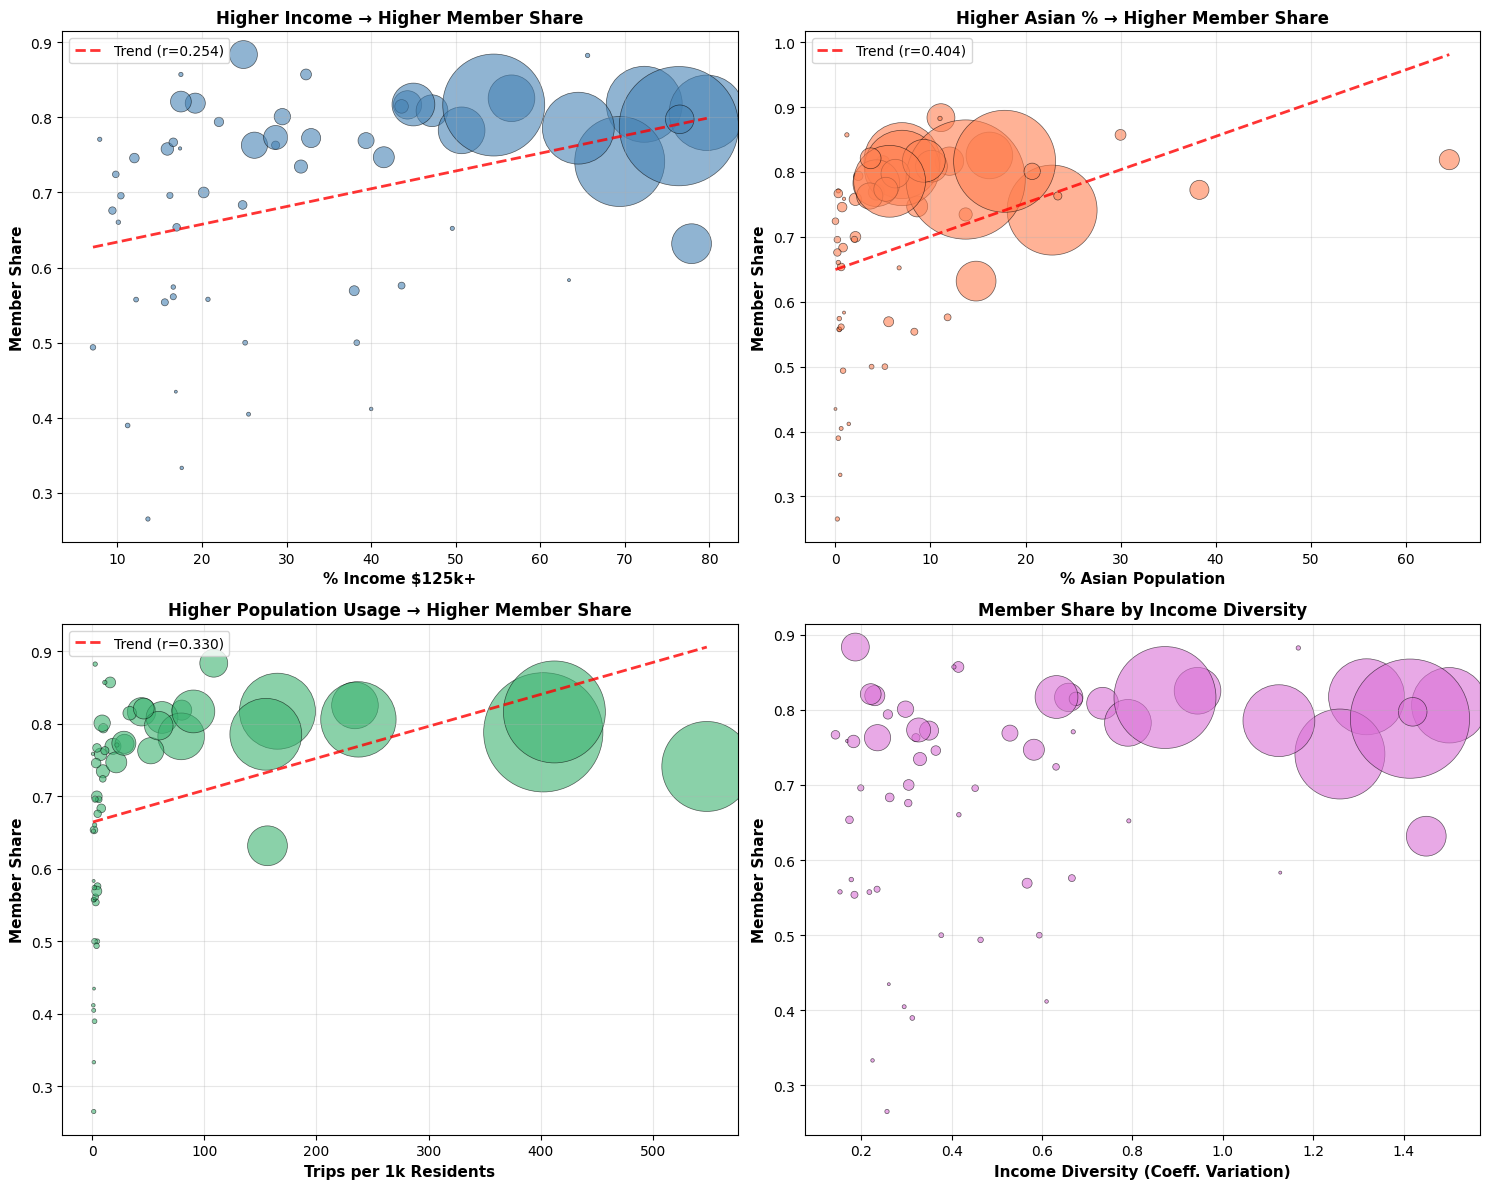

In [97]:
# Visualizations of Demographic-Ridership Relationships

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Income (Highest Bracket %) vs Member Share
ax1 = axes[0, 0]
scatter_data = community_summary[community_summary['total_trips'] > 20].copy()
ax1.scatter(scatter_data['income_125k_plus_pct'], scatter_data['member_share'], 
            s=scatter_data['total_trips']/5, alpha=0.6, color='steelblue', edgecolors='black', linewidth=0.5)
z = np.polyfit(scatter_data['income_125k_plus_pct'].dropna(), 
               scatter_data.loc[scatter_data['income_125k_plus_pct'].notna(), 'member_share'].dropna(), 1)
p = np.poly1d(z)
x_line = np.linspace(scatter_data['income_125k_plus_pct'].min(), scatter_data['income_125k_plus_pct'].max(), 100)
ax1.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label=f'Trend (r={correlations_with_member_share["income_125k_plus_pct"]:.3f})')
ax1.set_xlabel('% Income $125k+', fontsize=11, fontweight='bold')
ax1.set_ylabel('Member Share', fontsize=11, fontweight='bold')
ax1.set_title('Higher Income → Higher Member Share', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Asian % vs Member Share
ax2 = axes[0, 1]
ax2.scatter(scatter_data['asian_pct'], scatter_data['member_share'], 
            s=scatter_data['total_trips']/5, alpha=0.6, color='coral', edgecolors='black', linewidth=0.5)
z = np.polyfit(scatter_data['asian_pct'].dropna(), 
               scatter_data.loc[scatter_data['asian_pct'].notna(), 'member_share'].dropna(), 1)
p = np.poly1d(z)
x_line = np.linspace(scatter_data['asian_pct'].min(), scatter_data['asian_pct'].max(), 100)
ax2.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label=f'Trend (r={correlations_with_member_share["asian_pct"]:.3f})')
ax2.set_xlabel('% Asian Population', fontsize=11, fontweight='bold')
ax2.set_ylabel('Member Share', fontsize=11, fontweight='bold')
ax2.set_title('Higher Asian % → Higher Member Share', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Population Density (Trips per 1k) vs Member Share
ax3 = axes[1, 0]
density_data = scatter_data[scatter_data['trips_per_1k_residents'].notna()]
ax3.scatter(density_data['trips_per_1k_residents'], density_data['member_share'], 
            s=density_data['total_trips']/5, alpha=0.6, color='mediumseagreen', edgecolors='black', linewidth=0.5)
z = np.polyfit(density_data['trips_per_1k_residents'], density_data['member_share'], 1)
p = np.poly1d(z)
x_line = np.linspace(density_data['trips_per_1k_residents'].min(), density_data['trips_per_1k_residents'].max(), 100)
ax3.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label=f'Trend (r={correlations_with_member_share["trips_per_1k_residents"]:.3f})')
ax3.set_xlabel('Trips per 1k Residents', fontsize=11, fontweight='bold')
ax3.set_ylabel('Member Share', fontsize=11, fontweight='bold')
ax3.set_title('Higher Population Usage → Higher Member Share', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Income Diversity (Coefficient of Variation) vs Member Share
ax4 = axes[1, 1]
diversity_data = scatter_data[scatter_data['income_diversity_cv'].notna()]
ax4.scatter(diversity_data['income_diversity_cv'], diversity_data['member_share'], 
            s=diversity_data['total_trips']/5, alpha=0.6, color='orchid', edgecolors='black', linewidth=0.5)
ax4.set_xlabel('Income Diversity (Coeff. Variation)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Member Share', fontsize=11, fontweight='bold')
ax4.set_title('Member Share by Income Diversity', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('demographic_ridership_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

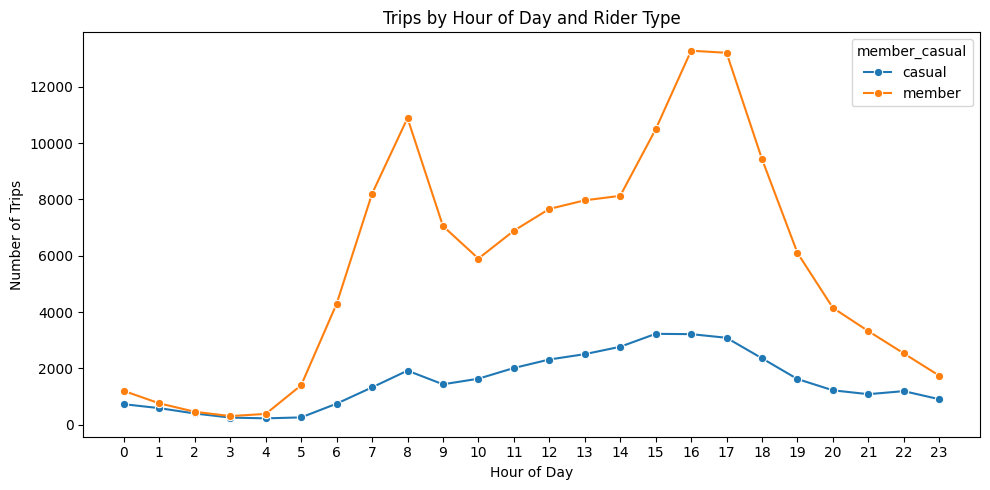

In [98]:
# Rides per hour of day by rider type
hourly_counts = (
    divvy_data
    .groupby(['hour_of_day', 'member_casual'])['ride_id']
    .count()
    .reset_index(name='trip_count')
)

plt.figure(figsize=(10,5))
sns.lineplot(
    data=hourly_counts,
    x='hour_of_day',
    y='trip_count',
    hue='member_casual',
    marker='o'
)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Trips by Hour of Day and Rider Type')
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()


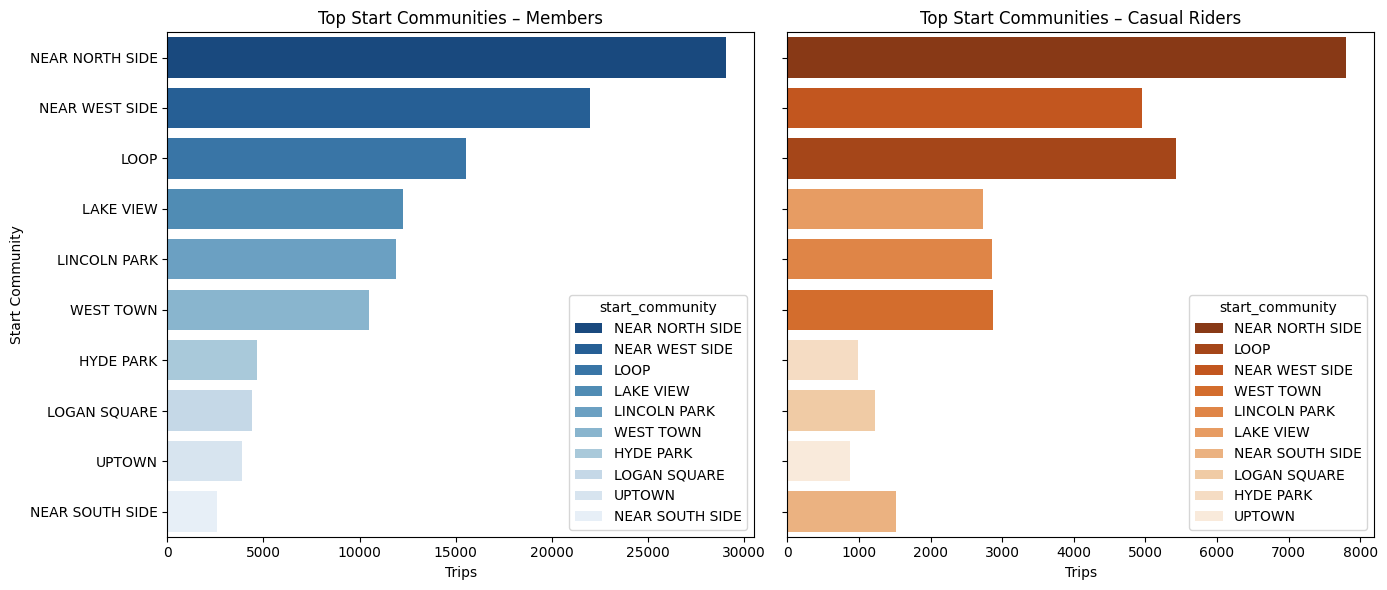

In [99]:
# Top start communities for members vs casual riders
top_n = 10

top_member_comm = (
    divvy_data[divvy_data['member_casual'] == 'member']
    .groupby('start_community')['ride_id']
    .count()
    .nlargest(top_n)
    .reset_index(name='member_trips')
)

top_casual_comm = (
    divvy_data[divvy_data['member_casual'] == 'casual']
    .groupby('start_community')['ride_id']
    .count()
    .nlargest(top_n)
    .reset_index(name='casual_trips')
)

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

sns.barplot(
    data=top_member_comm,
    x='member_trips',
    y='start_community',
    hue='start_community',
    ax=axes[0],
    palette='Blues_r',
    legend=True
)
axes[0].set_title('Top Start Communities – Members')
axes[0].set_xlabel('Trips')
axes[0].set_ylabel('Start Community')

sns.barplot(
    data=top_casual_comm,
    x='casual_trips',
    y='start_community',
    hue='start_community',
    ax=axes[1],
    palette='Oranges_r',
    legend=True
)
axes[1].set_title('Top Start Communities – Casual Riders')
axes[1].set_xlabel('Trips')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


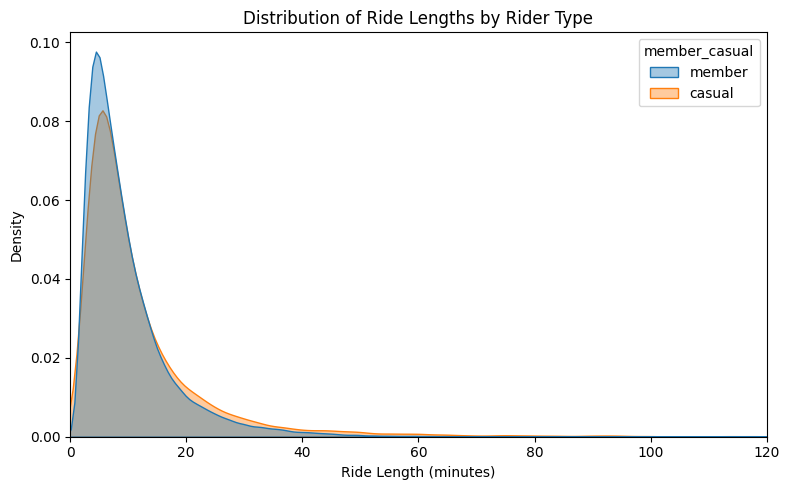

In [100]:
plt.figure(figsize=(8,5))

# Cap at 120 minutes for visibility
plot_data = divvy_data[divvy_data['ride_length_min'] <= 120].copy()

sns.kdeplot(
    data=plot_data,
    x='ride_length_min',
    hue='member_casual',
    fill=True,
    common_norm=False,
    alpha=0.4
)
plt.xlabel('Ride Length (minutes)')
plt.ylabel('Density')
plt.title('Distribution of Ride Lengths by Rider Type')
plt.xlim(0, 120)
plt.tight_layout()
plt.show()


C:\Users\Eduardo Sourd\AppData\Local\Temp\ipykernel_1676\1187166807.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['member_casual', 'day_of_week', 'hour_of_day'])['ride_id']


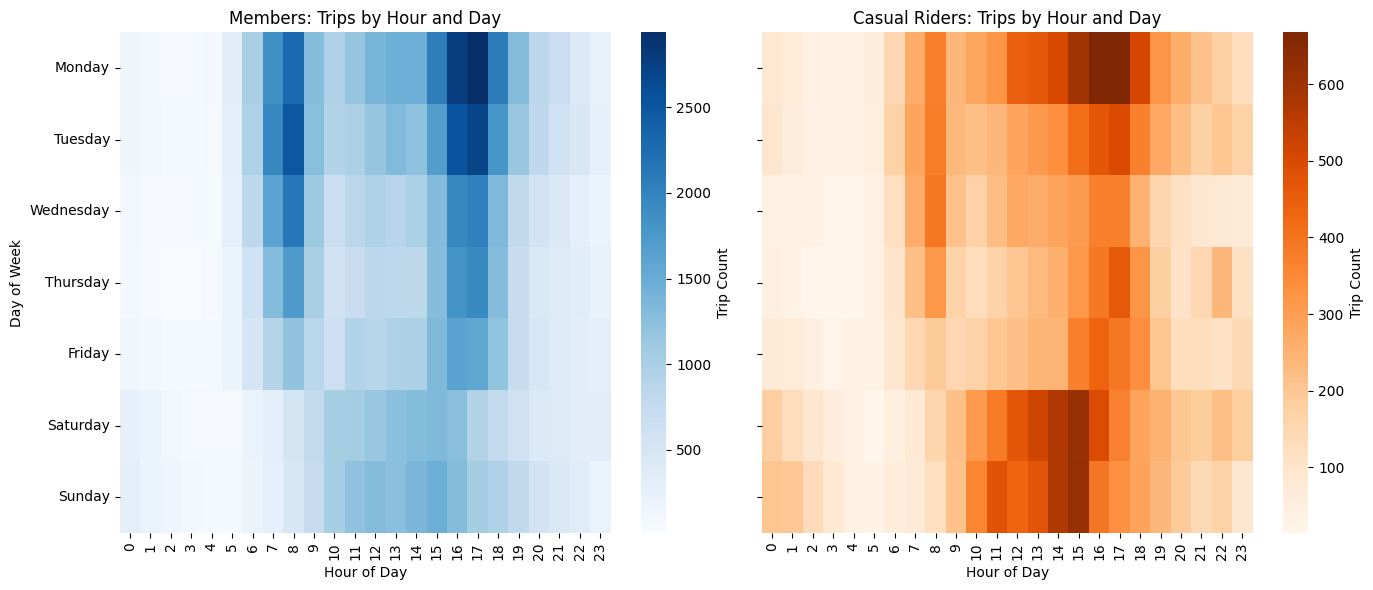

In [101]:
# Ensure a logical weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
divvy_data['day_of_week'] = pd.Categorical(divvy_data['day_of_week'], categories=weekday_order, ordered=True)


# Aggregate trips by hour and day for each rider type
hour_dow_counts = (
    divvy_data
    .groupby(['member_casual', 'day_of_week', 'hour_of_day'])['ride_id']
    .count()
    .reset_index(name='trip_count')
)

# Pivot into matrices for members and casuals
member_pivot = hour_dow_counts[hour_dow_counts['member_casual'] == 'member'].pivot(
    index='day_of_week', columns='hour_of_day', values='trip_count'
).reindex(index=weekday_order)

casual_pivot = hour_dow_counts[hour_dow_counts['member_casual'] == 'casual'].pivot(
    index='day_of_week', columns='hour_of_day', values='trip_count'
).reindex(index=weekday_order)

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

sns.heatmap(
    member_pivot,
    ax=axes[0],
    cmap='Blues',
    cbar_kws={'label': 'Trip Count'}
)
axes[0].set_title('Members: Trips by Hour and Day')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Day of Week')

sns.heatmap(
    casual_pivot,
    ax=axes[1],
    cmap='Oranges',
    cbar_kws={'label': 'Trip Count'}
)
axes[1].set_title('Casual Riders: Trips by Hour and Day')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()
